Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE" and remove every line containing the expression: "raise ..." (if you leave such a line your code will not run).

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebook!!!

Fill in your name and id number (numero matricola) below:

In [25]:
NAME = "Gioel Adriano Vencato"
ID_number = int("2005829")

---

# Classification on Wine Dataset

### Dataset description

We will be working with a dataset on wines from the UCI machine learning repository
(http://archive.ics.uci.edu/ml/datasets/Wine ). It contains data for 178 instances. 
The dataset is the results of a chemical analysis of wines grown in the same region
in Italy but derived from three different cultivars. The analysis determined the
quantities of 13 constituents found in each of the three types of wines. 

### The features in the dataset are:

- Alcohol
- Malic acid
- Ash
- Alcalinity of ash
- Magnesium
- Total phenols
- Flavanoids
- Nonflavanoid phenols
- Proanthocyanins
- Color intensity
- Hue
- OD280/OD315 of diluted wines
-Proline




We first import all the packages that are needed

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt


import numpy as np
import scipy as sp
from scipy import stats
from sklearn import datasets
from sklearn import linear_model

In [27]:
np.random.seed(ID_number)

# Perceptron
We will implement the perceptron and use it to learn a halfspace with 0-1 loss.

Load the dataset from scikit learn and then split in training set and test set (50%-50%) after applying a random permutation to the datset.

In [28]:
# Load the dataset from scikit learn
wine = datasets.load_wine()
# Get input and output data from the dataset
X = wine.data
Y = wine.target
# Create new labels
Y = np.where(Y == 0, -1, Y)
Y = np.where(Y == 2, -1, Y)
# Let's get the number of features
d = X.shape[1]

In [29]:
##### Helper functions, do not modify them. You will need them for the first TODO
def check_constraints(labels, all_possibile_labels, min_num_istances):
    # Count the number of occurrences using numpy
    unique, counts = np.unique(labels, return_counts=True)
    if len(all_possibile_labels) != len(unique):
        return True
    if (counts >= min_num_istances).all():
        return False
    else:
        return True
    
def need_new_shuffle(y_train, y_test, all_possibile_labels, min_num_istances): 
    return (check_constraints(y_train, all_possibile_labels, min_num_istances) or 
            check_constraints(y_test, all_possibile_labels, min_num_istances))

In [30]:
# TODO 1
# Write a function (create_train_val_test_datasets) which takes as input a dataset and returns 2 datasets: 
# S_t and S_test (different runs are supposed) to return different datasets.
# Write a function (create_train_val_test_datasets_with_constraints) which splits our data in S_t and S_test with 
# the additional constraint that in each dataset we MUST have more than min_num_istances per class.
# Each dataset is represented as a matrix m \times d (numpy ndarray), where m is the number of data and d is the 
# number of features.
# To solve this TODO use the functions we provide you: check_constraints and need_new_shuffle

def create_train_val_test_datasets(features : np.ndarray, labels: np.ndarray, m_t : int, m_test : int):
    '''
    Create training (S_t) and test (S_test) sets starting from a dataset. 
    This function shuffles the complete dataset before creating the subsets. 
    If you call this function twice it is expected to get different S_t, S_test. 
    
    :param features: NumPy ndarray containing all the input data we can use
    :param labels: NumPy ndarray containing all the labels we have
    :param m_t: Number of samples for the training dataset
    :param m_test: Number of samples for the test dataset
    
    :returns: (x_train, y_train, x_test, y_test)
    :rtype: tuple
        WHERE
        x_train : np.ndarray features in the training dataset
        y_train : np.ndarray labels in the training dataset
        x_test : np.ndarray features in the test dataset
        y_test : np.ndarray labels in the test dataset
    '''
    # SUGGESTION: Use the function np.random.permutation (see the documentation) to create a permutation of the 
    #             dataset indexes. Then use these shuffled indexes to create S_t, S_val, S_test
    # YOUR CODE HERE
    index_permutation = np.random.permutation(features.shape[0]) # Index permutation
    x_train = np.array([features[i] for i in index_permutation[0 : m_t]]) # Create the subset x_train of m_t elements
    y_train = np.array([labels[i] for i in index_permutation[0:m_t]]) # Create the subset y_train of m_t elements
    x_test = np.array([features[i] for i in index_permutation[m_t:m_t+m_test]]) # Create the subset x_test of m_test elements
    y_test = np.array([labels[i] for i in index_permutation[m_t:m_t+m_test]]) # Create the subset y_test of m_test elements
    return x_train, y_train, x_test, y_test


def create_train_val_test_datasets_with_constraints(features : np.ndarray, labels: np.ndarray, m_t : int, 
                                                    m_test : int, min_num_istances : int):
    '''
    Same as function above but now we are imposing the constraints: the splitted datasets are assumed to contain 
    at least min_num_istances per class.
    
    ...
    :param min_num_istances: Minimum number of istances per class in each of the splitted datasets
    ...
    
    '''
    all_possible_labels = np.unique(labels)
    # YOUR CODE HERE
    x_train, y_train, x_test, y_test = create_train_val_test_datasets(features,labels,m_t,m_test)
    while (need_new_shuffle(y_train,y_test,all_possible_labels,min_num_istances)): # While at least one of the 2 sets {y_train, y_test} has either the numbers of (1) or the numbers of (-1) less than min_num_istances, then the dataset is shuffled again. 
      x_train, y_train, x_test, y_test = create_train_val_test_datasets(features,labels,m_t,m_test)

    return x_train, y_train, x_test, y_test


m_t = 80
x_train, y_train, x_test, y_test = create_train_val_test_datasets_with_constraints(X,Y,m_t,len(Y)-m_t,25)

In [31]:
assert x_train.shape == (m_t,     x_train.shape[1]) # here we are comparing two tuples (it is an element wise comparison)
assert x_test.shape  == (len(Y)-m_t, x_test.shape[1])

In [32]:
# Let's add a 1 in front of each sample so that we can use a vector to describe all the coefficients of the model.
# Do not run this celle multiple times otherwise you will continue adding ones... 
# (we add the assert to avoid such issue)

assert x_train.shape[1] == d
assert x_test.shape[1] == d 

x_train = np.hstack((np.ones((x_train.shape[0],1)), x_train))
x_test  = np.hstack((np.ones((x_test.shape[0],1)),  x_test))

**TO DO 2** Now complete the function *perceptron*. Since the perceptron does not terminate if the data is not linearly separable, your implementation should return the desired output (see below) if it reached the termination condition seen in class or if a maximum number of iterations have already been run, where 1 iteration corresponds to 1 update of the perceptron weights. If the perceptron returns because the maximum number of iterations has been reached, you should return an appropriate model (the best seen along the iterations). 

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $max\_num\_iterations$: the maximum number of iterations for running the perceptron

The output values are:
- $best\_w$: the vector with the coefficients of the best model
- $best\_error$: the *fraction* of missclassified samples for the best model


**Auxiliary functions**

In order to correclty complete the perceptron function it is warmly recommended to define some auxiliary functions ("*find_missclassified*" and "*choose_missclassified*"). 


"__find_missclassified__"
This function looks for missclassified data points in the dataset $X$.

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $curr\_w$: the current value of the parameter vector *w*

The output value is:
- $missclassified\_indeces$: a numpy array cointaining all the missclassified indeces  


"__choose_missclassified__"
This function return one single index choosen from a array of indeces. If the array is empty it returns a non valid index: -1. 

The input parameters to pass are:
- $missclassified\_indeces$: numpy arrya containing missclassified indeces

The output value is:
- $index$: Integer (or np.int64) containing the choosen index


In [33]:
# TODO 2
def find_missclassified(X,Y,curr_w):
    # Here you can use np.argwhere to find which model predictions are correct (this is faster than a for loop)
    # but be carefull on the dimensions of your predictions vector and Y vector.
    # YOUR CODE HERE
    pred_array = np.matmul(X,curr_w).reshape(-1,) # Array containing the predicted value of the data
    diag_y = np.diag(Y) # Diagonal matrix where the element (i,i) contains Y[i] for every i=0,1,..,dim(Y)
    missclassified_indeces = np.argwhere(np.matmul(diag_y,pred_array) <= 0) # If Y[i]*X_i*w <= 0 then i is a missclassified sample
    return missclassified_indeces.reshape(-1,)

def choose_missclassified(missclassified_indeces):
    # YOUR CODE HERE
    if (len(missclassified_indeces) == 0):
      index = -1
    else:
      index = missclassified_indeces[np.random.permutation(len(missclassified_indeces))[-1]] # A random index is chosen at every iteration
    return index

def perceptron(X,Y,max_num_iterations):
    #INITIALIZATION
    curr_w = np.zeros(X.shape[1])
    best_w = curr_w
    num_samples = X.shape[0]
    best_error = num_samples+1  # max + 1 number of possible errors 
    
    missclassified_indeces = None   # You need to assign this variable o the proper value
    num_missclassified = None       # You need to assign this variable o the proper value
    index_missclassified = None     # You need to assign this variable o the proper value
    
    # YOUR CODE HERE
    missclassified_indeces = find_missclassified(X,Y,best_w)
    num_missclassified = missclassified_indeces.shape[0]
    index_missclassified = choose_missclassified(missclassified_indeces)
        
    num_iter = 1  
    while ((num_iter < max_num_iterations) & (num_missclassified > 0)): # If at least one of the 2 conditition is false then exit the while loop
        # Update rule
    # YOUR CODE HERE
        num_iter = num_iter + 1
        curr_w = curr_w + Y[index_missclassified] * X[index_missclassified]
        # Update missclassified data points and choose a new missclassified data point
        # YOUR CODE HERE
        missclassified_indeces = find_missclassified(X,Y,curr_w)
        num_missclassified = missclassified_indeces.shape[0] # Num_missclassified represents the number of error
        index_missclassified = choose_missclassified(missclassified_indeces)
        # Update (if necessary) the best error achieved together with the best parameter up to now
        # YOUR CODE HERE
        if (num_missclassified < best_error): # Update the best_error & best_w parameters if the number of errors decrease
          best_error = num_missclassified
          best_w = curr_w
    best_error = float(best_error)/float(num_samples)
    return best_w, best_error

In [34]:
index = choose_missclassified(np.array(list(range(100))))
assert type(index) == np.int64 or type(index) == int

In [35]:
#now run the perceptron for 100 iterations
w_found, training_error = perceptron(x_train, y_train,100)
print("Training error with 100 iterations: " + str(training_error))

Training error with 100 iterations: 0.225


In [36]:
# TODO 3 
# Write a function to compute the fraction of missclassified samples given two nd.array vectors of shape number of 
# data times 1 (column vectors)
def classification_loss(y_target : np.ndarray, predictions : np.ndarray) -> float:
    '''
    This function computes the fraction of missclassified samples given two vectors: true labels and predictions. 
    :param y_target: output labels
    :param predictions: predictions
    
    :return: Fraction of missclassified samples
    '''
    # YOUR CODE HERE
    missclassified = list()
    for i in range(0,y_target.shape[0]):
      if (predictions[i] != y_target[i]):
        missclassified.append(i) # Append one element to missclassified if the predicted value is incorrect
    missclassified_indeces = np.array(missclassified)  # Create array containing missclassified
    return missclassified_indeces.shape[0] / y_target.shape[0]

# Write a function to comptue the fraction of missclassified samples for a generic dataset given inputs, targets and 
# a vector w.
def compute_fraction_missclassified(X : np.ndarray, Y : np.ndarray, w : np.ndarray) -> float:
    '''
    This function computes the fraction of missclassified samples of model parametrized by w on the data X w.r.t. 
    targets Y. 
    :param X: input locations
    :param Y: targets
    :param w: parameters of the model to be tested
    
    :return: Fraction of missclassified samples
    '''
    # YOUR CODE HERE
    predicted_output = list()
    Y_labels = np.unique(Y) # Y is a generic binary class so it can contain different values from -1,1. Y_labels contains all the different elements in Y
    if (Y_labels[0] > Y_labels[1]): # Computing max and min between the 2 labels
      max = Y_labels[0]
      min = Y_labels[1]
    else:
      max = Y_labels[1]
      min = Y_labels[0]
    mean_labels = (Y_labels[0] + Y_labels[1])/2 # Average between max and min
    predictions = np.matmul(X,w)
    for i in range(0,X.shape[0]): # Append to predicted_output list the predicted element for each data point
      if (predictions[i] > mean_labels):
        predicted_output.append(max) 
      else:
        predicted_output.append(min)
    predicted_output = np.array(predicted_output)
    fraction_missclass = classification_loss(Y,predicted_output) # Computing the fraction of missclassified samples 
    return fraction_missclass

In [37]:
assert classification_loss(np.array([[1],[3]]), np.array([[1],[3]])) == 0
assert classification_loss(np.array([[1],[2]]), np.array([[1],[3]])) == 0.5
y_labels, y_predictions = np.random.choice(10, 1000000), np.random.choice(10, 1000000)
assert np.isclose(classification_loss(y_labels, y_predictions), 0.9, atol=0.01)
assert training_error == compute_fraction_missclassified(x_train, y_train, w_found)


We now use the best model $w\_found$ to predict the labels for the test dataset and print the fraction of missclassified samples in the test set (that is an estimate of the true loss).

In [38]:
print(f"Training Error for 100 iterations is {compute_fraction_missclassified(x_train, y_train, w_found):.4f}")
print(f"Test Error for 100 iterations is {compute_fraction_missclassified(x_test, y_test, w_found):.4f}")

Training Error for 100 iterations is 0.2250
Test Error for 100 iterations is 0.2551


In [39]:
#now run the perceptron for 10000 iterations
w_found, training_error = perceptron(x_train, y_train, 10000)
print(f"Training Error for 10000 iterations is {compute_fraction_missclassified(x_train, y_train, w_found):.4f}")
print(f"Test Error for 10000 iterations is {compute_fraction_missclassified(x_test, y_test, w_found):.4f}")

Training Error for 10000 iterations is 0.1375
Test Error for 10000 iterations is 0.2653


**TO DO 4**: Answer in the next cell (you do not need more than 5-7 lines):

1- Consider 100 iterations: what relation do you observe between the training error and the (estimated) true loss? Is this what you expected? Explain what you observe and why it does or does not conform to your expectations.

2- Consider 10000 iterations, what has changed? Explain what you observe and why it does or does not conform to your expectations.

YOUR ANSWER HERE
1. The model has been found such that it minimizes the error on the training data (100 iterations: this is the only condition that makes the perceptron algorithm stop because this number of iterations in not enough to separate the training dataset). On the other hand, on the test data i observe that the estimated true loss is not excessively higher than the training error but in general it assumes an high value as i expect it to be since 100 iterations are not even enough to do a "good job" on the training dataset.
2. If the number of iterations increases then it is plausible that the new line parametrized by w makes less errors on the training data. However, because of the new model, it can do worse, as it happens, on test data with respect to the one that has been found using 100 iterations. Finally, this does not conform to my expectations because i would like that also the estimated true loss decreases as the number of iterations increases.

# Logistic Regression
Now we use logistic regression, as implemented in Scikit-learn, to predict labels. We first do it for 2 labels and then for 3 labels. We will also plot the decision region of logistic regression.

We first load the dataset again.

In [40]:
import random
# Let's reinitialize the random seed 
random.seed(ID_number)
np.random.seed(ID_number)

# In the following we will keep the dataset with only two classes (which we aggregated before)
m_t = 80
x_train, y_train, x_test, y_test = create_train_val_test_datasets_with_constraints(X, Y, m_t, len(Y)-m_t, 25)

To define a logistic regression model in Scikit-learn use the instruction

$linear\_model.LogisticRegression(C=1e5)$

($C$ is a parameter related to *regularization*, a technique that
we will see later in the course. Setting it to a high value is almost
as ignoring regularization, so the instruction above corresponds to the
logistic regression you have seen in class.)

To learn the model you need to use the $fit(...)$ instruction and to predict you need to use the $predict(...)$ function. See the Scikit-learn documentation for how to use it (have a look at the logreg.score method too).

**TO DO** Define the logistic regression model, then learn the model using the training set and predict on the test set. Then print the fraction of samples missclassified in the training set and in the test set.

In [41]:
# TODO 5
# Logistic regression for 2 classes
# To compute the error rate (classification loss you can use the function "classification_loss" you built before)
# YOUR CODE HERE
logreg = linear_model.LogisticRegression(C = 1e5)
logreg = logreg.fit(x_train,y_train)
y_train_predicted = logreg.predict(x_train)
y_test_predicted = logreg.predict(x_test)
error_rate_training = classification_loss(y_train,y_train_predicted)
error_rate_test = classification_loss(y_test,y_test_predicted)
error_rate_test_sklearn = 1-logreg.score(x_test,y_test)
print("Error rate on training set: "+str(error_rate_training))
print("Error rate on test set: "+str(error_rate_test))
print(f"Compare the estimate of generalization with the sklearn implementation {error_rate_test_sklearn}")

Error rate on training set: 0.0125
Error rate on test set: 0.10204081632653061
Compare the estimate of generalization with the sklearn implementation 0.10204081632653061


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [42]:
assert np.isclose(error_rate_test, error_rate_test_sklearn)

Now we do logistic regression for classification with 3 classes.

In [43]:
random.seed(ID_number)
np.random.seed(ID_number)

X = wine.data
Y = wine.target

m_t = 80
x_train, y_train, x_test, y_test = create_train_val_test_datasets_with_constraints(X, Y, m_t, len(Y)-m_t, 20)

_, counts = np.unique(y_train, return_counts=True)
assert (counts >= 20).all()
_, counts = np.unique(y_test, return_counts=True)
assert (counts >= 20).all()

In [44]:
# TODO 6
# Logistic regression for 3 classes
# To compute the error rate (classification loss you can use the function "classification_loss" you built before)
# YOUR CODE HERE
logreg = linear_model.LogisticRegression(C = 1e5)
logreg = logreg.fit(x_train,y_train)
y_train_predicted = logreg.predict(x_train)
y_test_predicted = logreg.predict(x_test)
error_rate_training = classification_loss(y_train,y_train_predicted)
error_rate_test = classification_loss(y_test,y_test_predicted)
error_rate_test_sklearn = 1-logreg.score(x_test,y_test)
    
print("Error rate on training set: "+str(error_rate_training))
print("Error rate on test set: "+str(error_rate_test))
print(f"Compare the estimate of generalization with the sklearn implementation {error_rate_test_sklearn}")

Error rate on training set: 0.0
Error rate on test set: 0.07142857142857142
Compare the estimate of generalization with the sklearn implementation 0.0714285714285714


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [45]:
assert np.isclose(error_rate_test, error_rate_test_sklearn)

**TO DO 7**: Answer in the next cell (you do not need more than 5-7 lines):

1- Consider logistic regression on 2 and 3 classes what relation do you observe between the training error and the (estimated) true loss in both cases? Is this what you expected? Explain what you observe and why it does or does not conform to your expectations.

2- Consider logistic regression on 2 and perceptron with 10000 iterations, which one would you pick? Do you expect perceptron needs more iterations? Explain what you observe and why it does or does not conform to your expectations.


YOUR ANSWER HERE
1. In the case of logistic regression for 2 classes the training error is almost equal to 0 so the dataset seems to be linearly separable and the error on test dataset is close to 10%. In the other case the error rate on the training set is 0 so also in this case the data is linearly separable and i observe that the error rate on unseen data is smaller than the previous one (it is close to 7%).
2. I would pick logistic regression for 2 classes because both test error and training error observed are smaller with respect to the perceptron algorithm with 10000 iterations. I expect that perceptron needs more iterations since the trend of training error is improving and in particular it is decreasing. This conforms to my expectations because using logistic regression for 2 classes i observed that the data is linearly separable so the algorithm perceptron must converge in a finite number of iterations.

We now are going to plot prediction boundaries of a logistic regression model, in order to plot them we need to reduce the number of features to 2: pick two features and restrict the dataset to include only two features, whose indices are specified in the $feature$ vector below. Then split into training and test.

In [46]:
# TODO 8
#to make the plot we need to reduce the data to 2D, so we choose two features
features_list = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids',
                 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                 'Proline']
labels_list = ['class_0', 'class_1', 'class_2']

index_feature1 = 0  # You can choose the feature you prefer here
index_feature2 = 1  # You can choose the feature you prefer here
features = [index_feature1, index_feature2]

feature_name0 = features_list[features[0]]
feature_name1 = features_list[features[1]]

X = X[:,features]

# In the following we will keep the dataset with only two classes (which we aggregated before)
m_t = 80
x_train, y_train, x_test, y_test = create_train_val_test_datasets_with_constraints(X, Y, m_t, len(Y)-m_t, 20)

# Fit a model on the reduced set of fetures
# YOUR CODE HERE
logreg = linear_model.LogisticRegression(C = 1e5)
logreg.fit(x_train,y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
assert logreg.predict(x_test).shape == (x_test.shape[0], )

The code below uses the model in $logreg$ to plot the decision region for the two features chosen above, with colors denoting the predicted value. It also plots the points (with correct labels) in the training set. It makes a similar plot for the test set.

Text(0.5, 1.0, 'Test set')

<Figure size 288x216 with 0 Axes>

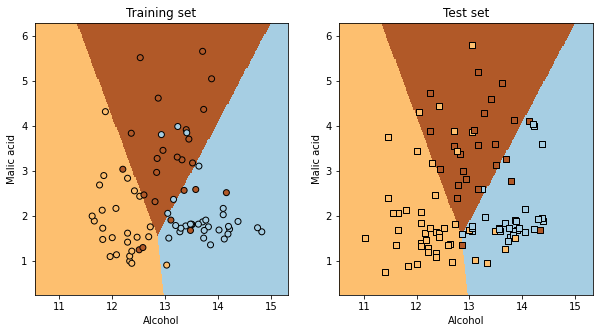

In [48]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(1, figsize=(4, 3))
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
axes[0].scatter(x_train[:, 0], x_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
axes[0].set_xlabel(feature_name0)
axes[0].set_ylabel(feature_name1)

axes[0].set_xlim(xx.min(), xx.max())
axes[0].set_ylim(yy.min(), yy.max())
axes[0].set_title('Training set')

# Put the result into a color plot
Z = Z.reshape(xx.shape)
axes[1].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the test points 
axes[1].scatter(x_test[:, 0], x_test[:, 1], c=y_test, edgecolors='k', cmap=plt.cm.Paired, marker='s')
axes[1].set_xlabel(feature_name0)
axes[1].set_ylabel(feature_name1)

axes[1].set_xlim(xx.min(), xx.max())
axes[1].set_ylim(yy.min(), yy.max())
axes[1].set_title('Test set')

**TO DO 9**: Answer in the next cell (you do not need more than 5-7 lines):

1- What is the shape of the decision boundaries? Why?

2- In this lower dimensional space, are the features linearily separable? What if you consider the entire feature vector (without any dimensionality reduction)?  


YOUR ANSWER HERE
1. The shape of the decision boundaries is found by using the training dataset and it is such that it maximizes the probability of the observed data so that most of data points are classified correctely. The same 3 lines paramatrized, in this case, by w1,w2,w3 are been used to classify unseen data.
2. I note that, in this lower dimensional space where i consider only 2 features: malic acid and alcohol, the features are not linearly separable as it is depicted in the figures. Instead, if i consider the entire feature vector the training dataset is linearly separable.